<h1><center>IMDB Reviews Sentimental Analysis</center></h1>


Data Source : https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,classification_report,log_loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
preprocessed_reviews = pd.read_csv('preprocessed_reviews.csv')
preprocessed_reviews.drop('Unnamed: 0',axis = 1,inplace = True)
preprocessed_reviews.head()


,review,sentiment
0,one review ha mention watch oz episod hook rig...,1
1,wonder littl product film techniqu veri unassu...,1
2,thought thi wa wonder way spend time hot summe...,1
3,basic famili littl boy jake think zombi hi clo...,0
4,petter mattei love time money visual stun film...,1


# Labeling the sentiment text

In [3]:
lb = LabelBinarizer()
sentiment_data  = lb.fit_transform(preprocessed_reviews['sentiment'])
print(sentiment_data.shape)

(50000, 1)


# Splitting

In [4]:
train_preprocessed_reviews = preprocessed_reviews.review[:40000]
test_preprocessed_reviews = preprocessed_reviews.review[40000:50000]
print("Shape of train set features",train_preprocessed_reviews.shape)
print("Shape of test set features",test_preprocessed_reviews.shape)
print('='*50)
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print("shape of train set labels",train_sentiments.shape)
print("Shape of test set labels",test_sentiments.shape)

Shape of train set features (40000,)
Shape of test set features (10000,)
shape of train set labels (40000, 1)
Shape of test set labels (10000, 1)


# Bag of Words

In [5]:
count_vect = CountVectorizer(min_df = 0,max_df = 1,ngram_range = (1,3))
train_reviews_cv = count_vect.fit_transform(train_preprocessed_reviews)
test_reviews_cv = count_vect.transform(test_preprocessed_reviews)

print("the type of count vectorizer ",type(train_reviews_cv))
print("the shape of train_reviews_cv out text BOW vectorizer ",train_reviews_cv.get_shape())
print("the shape of test_reviews_cv out text BOW vectorizer ",test_reviews_cv.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train_reviews_cv out text BOW vectorizer  (40000, 5834102)
the shape of test_reviews_cv out text BOW vectorizer  (10000, 5834102)


# TF-IDF

In [6]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_reviews_tv = tf_idf_vect.fit_transform(train_preprocessed_reviews)
test_reviews_tv = tf_idf_vect.transform(test_preprocessed_reviews)

print("the type of train and test count vectorizer ",type(train_reviews_tv))
print("the shape of train_reviews_tv out text TFIDF vectorizer ",train_reviews_tv.get_shape())
print("the shape of test_reviews_tv out text TFIDF vectorizer ",test_reviews_tv.get_shape())



the type of train and test count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train_reviews_tv out text TFIDF vectorizer  (40000, 72386)
the shape of test_reviews_tv out text TFIDF vectorizer  (10000, 72386)


# Logistic Regression

In [7]:
# Creating a logistic regression model
lr = LogisticRegression(penalty = 'l2',max_iter = 500,C = 1,random_state = 42)

* Train A model for Bag of words Vectorizer data

In [8]:
Bow_lr = lr.fit(train_reviews_cv,train_sentiments)
print(Bow_lr)
Bow_lr_predict = lr.predict(test_reviews_cv)
print(Bow_lr_predict)

LogisticRegression(C=1, max_iter=500, random_state=42)
[0 0 0 ... 0 0 0]


* Train a model for Tfidf vectorizer data

In [9]:
Tfidf_lr = lr.fit(train_reviews_tv,train_sentiments)
print(Tfidf_lr)
Tfidf_lr_predict = lr.predict(test_reviews_tv)
print(Tfidf_lr_predict)

LogisticRegression(C=1, max_iter=500, random_state=42)
[0 0 0 ... 0 0 0]


#### Accuracy or The Performance  of the model

In [10]:
Bow_lr_score = accuracy_score(test_sentiments,Bow_lr_predict)
print("Bow_lr_score : ",Bow_lr_score)

Tfidf_lr_score = accuracy_score(test_sentiments,Tfidf_lr_predict)
print("Tfidf_lr_score : ",Tfidf_lr_score)

Bow_lr_score :  0.6136
Tfidf_lr_score :  0.9035


In [11]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [12]:
Bow_lr_report=classification_report(test_sentiments,Bow_lr_predict,target_names=['Positive','Negative'])
print(Bow_lr_report)
Bow_lr_report=classification_report(test_sentiments,Tfidf_lr_predict,target_names=['Positive','Negative'])
print(Bow_lr_report)

              precision    recall  f1-score   support

    Positive       0.57      0.97      0.72      4993
    Negative       0.90      0.26      0.40      5007

    accuracy                           0.61     10000
   macro avg       0.73      0.61      0.56     10000
weighted avg       0.73      0.61      0.56     10000

              precision    recall  f1-score   support

    Positive       0.91      0.90      0.90      4993
    Negative       0.90      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#### Confusion Matrix

* For Bag of words Vectorizer

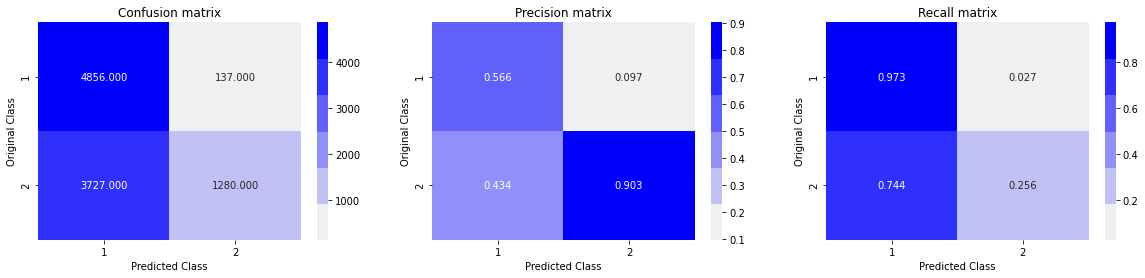

In [13]:
plot_confusion_matrix(test_sentiments,Bow_lr_predict)

* Observations:-
    * This confusion matrix seem to be not good because of its False Negative Rate is high and True Positive rate is very low in confusion matrix.
    * There is precision and Recall matrix is also note good.

* For Tfidf vectorizer

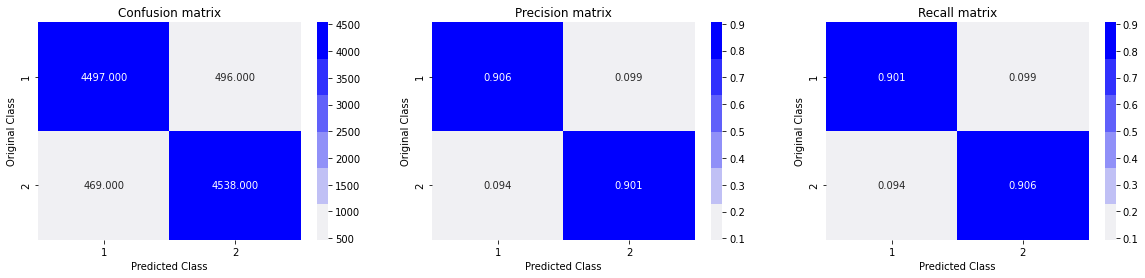

In [14]:
plot_confusion_matrix(test_sentiments,Tfidf_lr_predict)

* Observation:-
    * In confusion matrix diagonal boxes are dark blue it means TPR and TNR are high so model perform very well.
    * In precision and recall matrix also have digonal dark blue matrix and it is also similar so this is best for model.

# Stochastic gradient descent or Linear support vector machines 

* By the Calibrated model that ensure that model is not going to overfit on data.


In [15]:
svm = SGDClassifier(loss = 'hinge',penalty = 'l2',random_state = 4)

* Train a model for Bag of words Vectorizer data

In [16]:
svm.fit(train_reviews_cv,train_sentiments)
sig_clf = CalibratedClassifierCV(svm,method ='sigmoid' )
sig_clf.fit(train_reviews_cv,train_sentiments)
Bow_svm_predict_prob = sig_clf.predict_proba(test_reviews_cv)

print("The test log loss is : ",log_loss(test_sentiments, Bow_svm_predict_prob, labels=svm.classes_, eps=1e-15))

Bow_svm_predict_prob = sig_clf.predict_proba(train_reviews_cv)
print("The train log loss is : ",log_loss(train_sentiments, Bow_svm_predict_prob, labels=svm.classes_, eps=1e-15))

Bow_svm_predict = svm.predict(test_reviews_cv)
print(Bow_lr_predict)

The test log loss is :  0.6931477250440968
The train log loss is :  0.6931469578638504
[0 0 0 ... 0 0 0]


* Train a model for Tfidf Vectorizer data

In [17]:
svm.fit(train_reviews_tv,train_sentiments)
sig_clf = CalibratedClassifierCV(svm,method ='sigmoid' )
sig_clf.fit(train_reviews_tv,train_sentiments)
Tfidf_svm_predict_prob = sig_clf.predict_proba(test_reviews_tv)
print(log_loss(test_sentiments, Tfidf_svm_predict_prob, labels=svm.classes_, eps=1e-15))

Tfidf_svm_predict_prob = sig_clf.predict_proba(train_reviews_tv)
print(log_loss(train_sentiments, Tfidf_svm_predict_prob, labels=svm.classes_, eps=1e-15))

print(Tfidf_lr)
Tfidf_svm_predict = svm.predict(test_reviews_tv)
print(Tfidf_lr_predict)

0.24036053005954355
0.1647989988041704
LogisticRegression(C=1, max_iter=500, random_state=42)
[0 0 0 ... 0 0 0]


 There is log loss of train and test data is minimum so model is good and not overfit on data

#### Accuracy or The Performance  of the model

In [18]:
Bow_svm_score = accuracy_score(test_sentiments,Bow_svm_predict)
print("Bow_svm_score : ",Bow_svm_score)

Tfidf_svm_score = accuracy_score(test_sentiments,Tfidf_svm_predict)
print("Tfidf_svm_score : ",Tfidf_svm_score)

Bow_svm_score :  0.5551
Tfidf_svm_score :  0.9017


In [19]:
Bow_svm_report=classification_report(test_sentiments,Bow_svm_predict,target_names=['Positive','Negative'])
print(Bow_svm_report)
Tfidf_svm_report=classification_report(test_sentiments,Tfidf_svm_predict,target_names=['Positive','Negative'])
print(Tfidf_svm_report)

              precision    recall  f1-score   support

    Positive       0.53      0.99      0.69      4993
    Negative       0.95      0.12      0.21      5007

    accuracy                           0.56     10000
   macro avg       0.74      0.56      0.45     10000
weighted avg       0.74      0.56      0.45     10000

              precision    recall  f1-score   support

    Positive       0.91      0.89      0.90      4993
    Negative       0.89      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#### Confusion Matrix

* For Bag of words Vectorizer

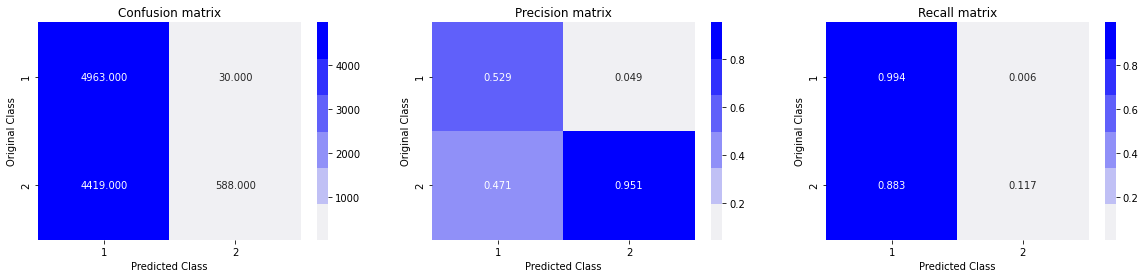

In [20]:
plot_confusion_matrix(test_sentiments,Bow_svm_predict)

* For Tfidf Vectorizer

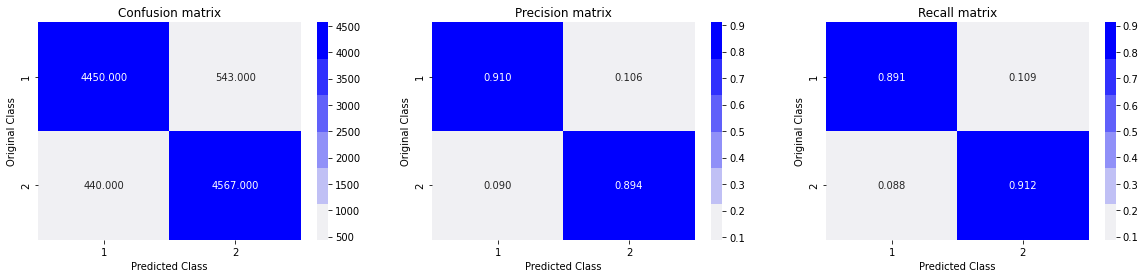

In [21]:
plot_confusion_matrix(test_sentiments,Tfidf_svm_predict)

# Multinomial Naive Bayes

In [22]:
MNB = MultinomialNB()

* Train a model for Bags of word Vectorizer data

In [23]:
Bow_MNB = MNB.fit(train_reviews_cv,train_sentiments)
print(Bow_MNB)

Bow_MNB_predict = MNB.predict(test_reviews_cv)
print(Bow_lr_predict)

MultinomialNB()
[0 0 0 ... 0 0 0]


* Train a model for Tfidf Vectorizer data

In [24]:
Tfidf_MNB = MNB.fit(train_reviews_tv,train_sentiments)
print(Tfidf_MNB)
Tfidf_MNB_predict = MNB.predict(test_reviews_tv)
print(Tfidf_MNB_predict)

MultinomialNB()
[0 0 0 ... 0 0 0]


#### Accuracy or The Performance  of the model

In [25]:
Bow_MNB_score = accuracy_score(test_sentiments,Bow_MNB_predict)
print("Bow_svm_score : ",Bow_MNB_score)

Tfidf_MNB_score = accuracy_score(test_sentiments,Tfidf_MNB_predict)
print("Tfidf_MN_score : ",Tfidf_MNB_score)

Bow_svm_score :  0.7521
Tfidf_MN_score :  0.8873


In [26]:
Bow_MNB_report=classification_report(test_sentiments,Bow_MNB_predict,target_names=['Positive','Negative'])
print(Bow_MNB_report)
Tfidf_MNB_report=classification_report(test_sentiments,Tfidf_MNB_predict,target_names=['Positive','Negative'])
print(Tfidf_MNB_report)

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.76      4993
    Negative       0.76      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.89      0.88      0.89      4993
    Negative       0.88      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



#### Confusion Matrix

*  For Bag of words Vectorizer

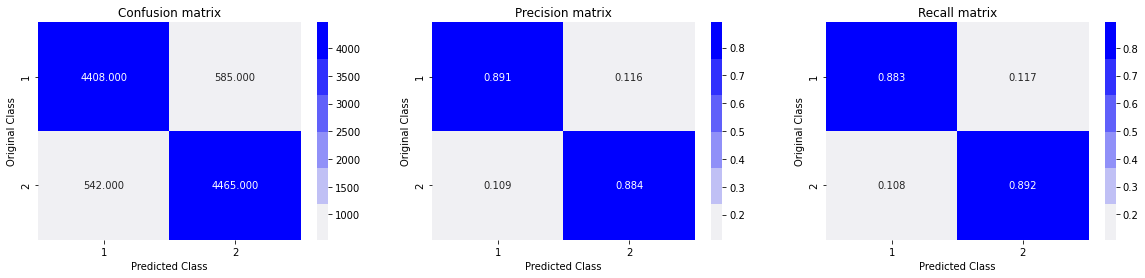

In [27]:
plot_confusion_matrix(test_sentiments,Tfidf_MNB_predict)

* For Tfidf Vectorizer

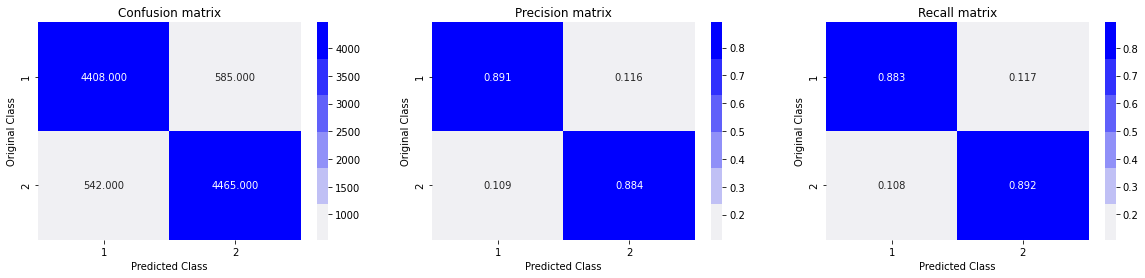

In [28]:
plot_confusion_matrix(test_sentiments,Tfidf_MNB_predict)

* Conclusions:-
    * Bag of words vectorizer is worst vectorizer for any model.
    * We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector machines.